In [15]:
import warnings
warnings.simplefilter(action='ignore',category=DeprecationWarning)
# warnings.simplefilter(action='ignore', category=)
import mbuild 
import foyer

import parmed
import parmed.unit as u

from openmm import app as mm
import openmm  as omm

In [ ]:
butanol1 = parmed.load_file(r'Butanol-1\Structure.pdb')
_ff = foyer.Forcefield(r'Butanol-1\FF.xml')
# _ff = foyer.forcefields.load_OPLSAA()
butanol1 = _ff.apply(butanol1)

In [ ]:
print(foyer.forcefields.get_forcefield_paths()[0])

In [61]:
oplsaa= foyer.forcefields.load_OPLSAA()

butanol1= mbuild.load(r'Butanol-1\Structure_simple.pdb')
butanol1.energy_minimize()
butanol1.name='Butanol'

ocm2= mbuild.load(r'OCM-2\Structure_simple.pdb')
ocm2.energy_minimize()
ocm2.name='OCM'


# Combine box

In [79]:
box_but = mbuild.Box([2,2,2])

box_but2 = mbuild.fill_box(
    box=box_but,
    compound=butanol1,
    n_compounds=100,
)

box_ocm = mbuild.Box([2,2,2])
box_ocm2 = mbuild.fill_box(
    box=box_ocm,
    compound=ocm2,
    n_compounds=100
)

In [65]:
box_but3 = oplsaa.apply(box_but2)
print('**')
box_ocm3 = oplsaa.apply(box_ocm2)

**


In [66]:
box_all=box_ocm3+box_but3

In [71]:
system = box_all.createSystem(nonbondedMethod=mm.NoCutoff,
                    constraints=mm.HBonds,
                    implicitSolvent=mm.GBn2,
                    implicitSolventSaltConc=0.1 * u.moles / u.liter,)

In [73]:
integrator = omm.LangevinIntegrator(
                        300*u.kelvin,       # Temperature of heat bath
                        1.0/u.picoseconds,  # Friction coefficient
                        2.0*u.femtoseconds, # Time step
)

simulation = mm.Simulation(box_all.topology,system,integrator,omm.Platform.getPlatformByName('CUDA'))
simulation.context.setPositions( box_all.positions)

In [74]:
simulation.minimizeEnergy(maxIterations=500)

In [78]:
## Writing pdb with connections
positions = simulation.context.getState(getPositions=True).getPositions()
mm.PDBFile.writeFile(simulation.topology,positions,open('out.pdb','w'))

# Filled box

In [24]:
# box = mbuild.fill_box(
#     compound=[butanol1,ocm2],
#     compound_ratio=[0.5,0.5],
#     box=[5,5,5],
#     density=1000
# )

box = mbuild.Box([5,5,5])
box2 = mbuild.fill_box(
    compound=ocm2,
    n_compounds=100,
    box=box,
)
box3 = mbuild.solvate(solute=box2, solvent=butanol1, n_solvent=100, box=box)


In [41]:
system = oplsaa.apply(box3)

In [58]:
class MSDReporter:
    def __init__(self, interval, simulation, dt):
        self.interval = interval
        state0 = simulation.context.getState(getPositions=True, enforcePeriodicBox=False)
        self.x0 = state0.getPositions(asNumpy=True).value_in_unit(u.centimeter)
        self.dt = dt.value_in_unit(u.second)
        self.label = dict(Time=[], MSD=[])

    def describeNextReport(self, simulation):
        steps = self.interval - simulation.currentStep % self.interval
        return (steps, True, False, False, False, False)

    def report(self, simulation, state):
        x = state.getPositions(asNumpy=True).value_in_unit(u.centimeter)
        msd = np.mean(np.linalg.norm((x - self.x0), axis=1) ** 2)
        time = state.getStepCount() * self.dt
        self.label['Time'].append(time)
        self.label['MSD'].append(msd)

In [67]:
system2 = system.createSystem(nonbondedMethod=mm.NoCutoff,
                    constraints=mm.HBonds,
                    implicitSolvent=mm.GBn2,
                    implicitSolventSaltConc=0.1 * u.moles / u.liter,)
integrator = omm.LangevinIntegrator(
                        300*u.kelvin,       # Temperature of heat bath
                        1.0/u.picoseconds,  # Friction coefficient
                        2.0*u.femtoseconds, # Time step
)
platform = omm.Platform.getPlatformByName('CUDA')
simulation = mm.Simulation(system.topology,system2,integrator,platform)
simulation.context.setPositions( system.positions)

In [68]:
simulation.minimizeEnergy(maxIterations=500)

In [57]:
import sys
import numpy as np

In [70]:
rep = MSDReporter(100,simulation,2.0*u.femtosecond)
simulation.reporters.append(rep)
simulation.reporters.append(mm.StateDataReporter(sys.stdout, 100, step=True, potentialEnergy=True,
                              kineticEnergy=True, temperature=True,))


In [71]:
simulation.reporters

In [74]:
simulation.step(9000)

1100,-20377.673828125,16384.848388609244,268.16959960754554
1200,-20043.359375,16721.023176615592,273.67174745533936
1300,-19464.6953125,16840.309735114686,275.6241017202408
1400,-19474.9140625,17247.90064752847,282.29511198492327
1500,-18841.76171875,17208.61859641294,281.65218556475946
1600,-18794.21484375,17478.938746951986,286.076495440358
1700,-18489.90234375,17596.657746359007,288.0031935817413
1800,-18665.787109375,17704.635876881657,289.7704636438043
1900,-18850.13671875,17995.36294832034,294.52877208179916
2000,-18797.865234375,17938.343877994805,293.5955451823777
2100,-18546.0,17671.744853868615,289.2321387070767
2200,-18666.30078125,17805.172695224406,291.4159423007527
2300,-18500.203125,18027.015226644464,295.046822575983
2400,-18121.046875,17954.756594394334,293.86417089565515
2500,-18114.1484375,17971.810690203216,294.14329401820515
2600,-18011.84375,18302.79569047969,299.5605009947403
2700,-18163.3828125,18487.74103981466,302.58748782453097
2800,-17849.65625,17952.026390

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

In [79]:
df=pd.DataFrame(rep.label)

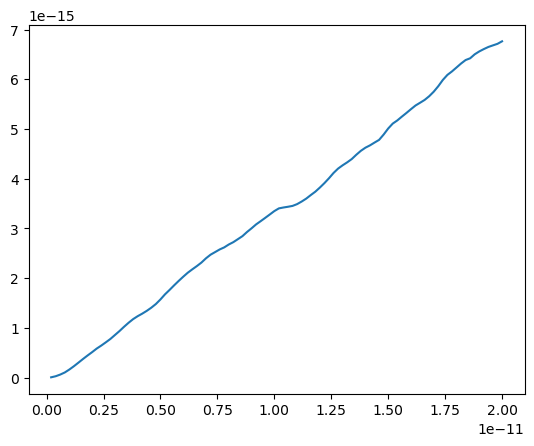

In [82]:
plt.plot(df['Time'],df['MSD'])

In [92]:
test_gro =parmed.gromacs.GromacsGroFile.parse(r'D:\WORKS\MolecularModeling\Simple_MD\butane\butane.gro')

In [99]:
test_top = parmed.gromacs.GromacsTopologyFile(r'D:\WORKS\MolecularModeling\Simple_MD\test\box.top')

In [101]:
test_top.box = test_gro.box
test_top.positions = test_gro.positions

In [103]:
test_gro

<Structure 15 atoms; 1 residues; 14 bonds; PBC (orthogonal); NOT parameterized>

In [109]:
but_itp=parmed.load_file(r'D:\WORKS\MolecularModeling\Simple_MD\test\clear\butane_clear.itp')
ocm_itp=parmed.load_file(r'D:\WORKS\MolecularModeling\Simple_MD\test\clear\ocm_crear.itp')

In [111]:
a=but_itp+ocm_itp

In [126]:
a.write('combined_ff2.xml')

In [127]:
a.save('combined_ff')

ValueError: Could not determine file type of combined_ff